In [14]:
import astropy.units as u
import astropy.constants as c
from astropy.modeling.physical_models import BlackBody
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps,trapz
from scipy.interpolate import interp1d
import warnings
import pandas as pd
import glob
import sys
import os
notebook_directory = os.getcwd()
sys.path.append(notebook_directory)

class SED:
    '''
    PURPOSE:
        Create an SED class to generate model spectrum
        
    INPUTS:
        mag: magnitude of source
        temperature: temperature of source
        wave_start: starting wavelength of spectrum
        wave_end: ending wavelength of spectrum
    '''
    # Initialize the class
    def __init__(self, mag, temperature, wave_start, wave_stop):
  
        # Define variables
        self.mag = mag
        self.temperature = temperature*u.K

        # Define the wavelength range
        self.wave_start = wave_start*u.AA
        self.wave_stop = wave_stop*u.AA

    def blackbody_spectrum(self):

        '''
        PURPOSE:
                This function creates a blackbody spectrum based on the temperature and magnitude of the star.

        INPUTS:
                        [mag; float]: The magnitude of the star
                [temperature; float]: The temperature of the star
                 [wave_start; float]: The starting wavelength of the spectrum
                  [wave_stop; float]: The ending wavelength of the spectrum

        OUTPUTS:
                          [wavelength; np.array, float]: The wavelength array of the blackbody spectrum
                [normalized_spectrum,; np.array, float]: The normalized blackbody spectrum

        AUTHOR:
                Tim M. Sept. 1 2023.
        '''

        # Create the blackbody spectrum
        blackbody_model = BlackBody(self.temperature, scale = 1*u.erg/u.s/u.cm**2/u.sr/u.AA)

        # Normalize the spectrum
        self.wavelength = np.linspace(self.wave_start, self.wave_stop, 100_000)

        # Define the reference spectrum
        self.model_spectrum = blackbody_model(self.wavelength)
        
        # Normalize the spectrum
        ref_spectrum = BlackBody(temperature = 9_700*u.K, scale = 1*u.erg/u.s/u.cm**2/u.sr/u.AA)

        # Normalize the spectrum
        normalize = (3.63e-9*u.erg/u.cm**2/u.s/u.AA)/(ref_spectrum(5500*u.AA)*u.sr) 

        # Define the normalized spectrum
        self.normalized_spectrum = self.model_spectrum*u.sr*normalize*10.**(-0.4*self.mag)
        
        return self.wavelength, self.normalized_spectrum
    
    def photon_spectrum(self,plot=False):
        '''
        PURPOSE:
            Create a photon spectrum
        INPUTS:
            Self
        OUTPUTS:
            photon_spectrum, an array in units of photons per second per cm^2 per Angstrom
        '''
                
        with warnings.catch_warnings():            
            warnings.filterwarnings("ignore", category=RuntimeWarning)          
            wavelength,normalized_spectrum = SED.blackbody_spectrum(self)       
            light_speed = c.c.to(u.cm/u.s)
            h = c.h.to(u.erg*u.s)
            photon_spectrum = normalized_spectrum*(5500*u.AA.to(u.cm)*u.cm)/(h*light_speed)
        
        # Create spectrum plot
        if plot==True:
            fig,ax = plt.subplots(1, 1, figsize = (10, 8))
            ax.set_xlabel('Wavelength ($\AA$)')
            ax.set_ylabel('Flux Density (photons $s^{-1} cm^{-2} \AA^{1})$')
            ax.plot(wavelength, photon_spectrum)
            plt.show()
        
        return wavelength,photon_spectrum
    
class BandPass:
    '''
    PURPOSE: Create a class for bandpass
    
    INPUTS:
        filter: filter used for observation, supported filter inputs are 'B','V','R','I'
    '''
    # Initialize the bandpass class
    def __init__(self, filter):

        # For the Johnson filter system:
        filter_table = pd.read_csv(notebook_directory+'/filter_data/'+filter+'.dat',delimiter='\t')

        self.filter_wavelength = filter_table['wavelength']

        self.filter_transmission = filter_table['transmission']
            
    def filter_SED(self, wavelength, normalized_spectrum,plot=False):

        ''' 
        PURPOSE:
                Function that convolves the normalized spectrum with a filter response function.

        INPUTS:
                wavelength: array wavelength of spectrum 
                normalized_spectrum: array for normalized spectrum 

        OUTPUTS:
                [convolved_spectrum; np.array, float]:  Normalized spectrum convolved with the filter response.

        AUTHOR:
                Tim M. Sept. 1 2023.
        '''

        # Interpolate the filter response
        interpolate = interp1d(self.filter_wavelength, self.filter_transmission,kind='cubic',fill_value=0.0,bounds_error=False)
        self.interpolated_filter_values = interpolate(wavelength.value)/100 
        # Multiply the normalized spectrum by the interpolated filter values
        filtered_spectrum = normalized_spectrum*self.interpolated_filter_values
        
        
        if plot==True:
            fig,ax = plt.subplots(1, 1, figsize = (10, 8))
            max = normalized_spectrum.max()
            
            ax.set_xlabel('Wavelength ($\AA$)')
            ax.set_ylabel('Flux Density (photons $s^{-1} cm^{-2} \AA^{1})$')
            ax.plot(wavelength.value, normalized_spectrum,label='Photon Spectrum')
            ax.plot(wavelength.value, self.interpolated_filter_values*max,label='Filter')
            ax.plot(wavelength.value, filtered_spectrum, label= 'Filtered Spectrum')
            plt.legend()
            plt.show()
        
        
        return filtered_spectrum
    
class Telescope:
    '''
    PURPOSE:
        Define telescope parameters to determine collecting area
    INPUTS:
        diameter: diameter of primary mirror
        units: units of length for diameter
        
            
    '''
    def __init__(self,diameter,units):
        if units == 'cm':
            self.diameter = diameter*u.cm
        if units == 'm':
            self.diameter = diameter*u.m.to(u.cm)*u.cm
        if units == 'mm':
            self.diameter = diameter*u.mm.to(u.cm)*u.cm
    
    def calc_area(self):    
        area = np.pi*(self.diameter/2)**2
        return area
   
    def mirror(self):
            mirror_efficiency = 1.0
            return mirror_efficiency
    
class atmosphere:
    '''
    PURPOSE:
        Define absorption due to atmospheric conditions
        
    INPUTS:
        quality: Either 'good' or 'bad' observing conditions
    '''
    
    def __init__(self,quality):
        if quality=='good':
            self.atm = 0.8
        if quality=='bad':
            self.atm = 0.4
    def get_atm(self):
        atm = self.atm
        return atm
            
class detector:
    def __init__(self,camera_cost):
        self.camera_cost = camera_cost

    def detector_efficiency(self):   
    
        if self.camera_cost == '$$$':
            QE = 0.5
        if self.camera_cost == '$':
            QE = 0.08
        return QE
    
class Counts_Equation:
    '''
    PURPOSE:
        Creates a class representing observing conditions
        
    INPUTS:
        model_SED: SED class with given temperature and magnitude
        filter: filter class with bandpass argument
        telescope: telescope class with diameter argument
        atmosphere: class atmosphere with quality argument
        detector: class detector with camera_cost argument
        
    '''
    def __init__(self,SED_model,filter,telescope,atmosphere,detector):
        
        self.wavelength,self.photon_spectrum = SED_model.photon_spectrum()
        self.bandpass = BandPass(filter)
        self.convolved_spectrum = self.bandpass.filter_SED(self.wavelength, self.photon_spectrum)
        
        
        self.area = telescope.calc_area()
        self.mirror = telescope.mirror()

        self.atm = atmosphere.get_atm()
        self.QE = detector.detector_efficiency()
        
    def get_counts(self):
        '''
        PURPOSE:
            calculate the expected counts per second given the class's attributes
        
        INPUTS:
            none
        
        RETURNS:
            counts, number in photons per second
        '''
        
        adjusted_spectrum = self.convolved_spectrum*self.area*self.atm*self.mirror*self.QE
        counts = simps(adjusted_spectrum, wavelength)
        return counts

In [11]:
# Initialize the SED class
model = SED(mag = 20, temperature = 9700, wave_start = 1, wave_stop = 10000)

# Create the spectrum
wavelength,spectrum = model.photon_spectrum()

In [12]:
sky_data = pd.read_csv(notebook_directory+'/sky_data/sky.csv')



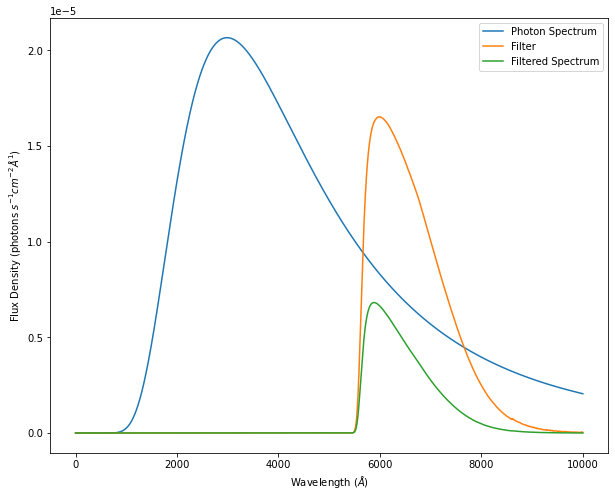

In [16]:
# Initialize the BandPass class
Vband = BandPass('R')

# Convolve the spectrum with the filter response
filtered_spectrum = Vband.filter_SED(wavelength, spectrum,plot=True)



In [18]:
model_SED = SED(mag = 20, temperature = 9700, wave_start = 1, wave_stop = 10000)


timstelescope = Telescope(60,'cm') #create telescope


LasCruces = atmosphere('good') #create atmosphere conditions

camera = detector('$$$') #create detector


In [19]:
observation = Counts_Equation(model_SED,                              #initialize observation
                              filter='V',telescope=timstelescope,
                              atmosphere=LasCruces,detector=camera)

counts = observation.get_counts()

print(np.round(counts,2),'photons per second')

9.74 photons per second
